## Goals:
0. enable GPU for faster training
1. split data into anomalous.npy and nonanomalous.npy
2. train an autoencoder on nonanomlous.npy for 500 epochs
3. save loss for each epoch
4. plot the graph of epochs vs loss
5. now pass the total non anomlous and anomlouls on trained autoencoder get loss and plot a histogram to compare the loss.

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from tensorflow import keras
import transformers

In [ ]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [ ]:
'''# Set GPU memory growth (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)'''

1 Physical GPUs, 1 Logical GPUs


## Extract Embeddings

In [ ]:
df_non_anomalous = pd.read_csv("https://raw.githubusercontent.com/Lordvarun23/Rare-Disease-Identification-with-Federated-Learning/main/data/anomalous.csv")
df_non_anomalous.head()

,disease,preprocessed_symptom
0,Fungal infection,itching irritating sensation makes want scratc...
1,Fungal infection,rash area irritated swollen skin many rashes i...
2,Fungal infection,itching irritating sensation makes want scratc...
3,Fungal infection,itching irritating sensation makes want scratc...
4,Fungal infection,itching irritating sensation makes want scratc...


In [ ]:
sentences = list(df_non_anomalous['preprocessed_symptom'].values)
print("No of sentences:",len(sentences))

No of sentences: 360


In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Load BioBERT model and tokenizer
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
model = model.to(device)

In [ ]:
# Forward pass to get embeddings
res = []
with torch.no_grad():
    for i in range(0,len(sentences),10):
      inputs = tokenizer(sentences[i:i+10], return_tensors="pt", padding=True, truncation=True).to(device)
      outputs = model(**inputs)

      # Extract embeddings from the last layer (CLS token)
      embeddings = outputs.last_hidden_state[:, 0, :]

      # Convert embeddings to a NumPy array
      embeddings_np = list(embeddings.cpu().numpy())

      res.extend(embeddings_np)

# Print the embeddings
embeddings = np.array(res)
print("Embeddings shape:", embeddings.shape)
#print(embeddings_np)

Embeddings shape: (360, 768)


In [ ]:
#saving the embeddings
np.save("embeddings_anomalous",embeddings)

## Train an auntoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Convert numpy array to PyTorch tensor
embeddings = np.load('embeddings_non_anomalous.npy')
tensor_data = torch.Tensor(embeddings)

In [ ]:
batch_size = 128
train_dataset = TensorDataset(tensor_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the Autoencoder model with additional layers
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 768)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Instantiate the model and move it to GPU
autoencoder = Autoencoder().cuda()

# Mean Square Error Loss
criterion = nn.MSELoss()

# Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

# Number of epochs
num_epochs = 500

In [ ]:
# Training loop
loss_epochs = []
for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data[0].cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)

        # Compute the loss
        loss = criterion(outputs, inputs)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Print the loss after each epoch
    loss_epochs.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model if needed
torch.save(autoencoder.state_dict(), 'autoencoder_model500epochs_8latent.pth')

Epoch [1/500], Loss: 0.0182
Epoch [2/500], Loss: 0.0119
Epoch [3/500], Loss: 0.0105
Epoch [4/500], Loss: 0.0093
Epoch [5/500], Loss: 0.0084
Epoch [6/500], Loss: 0.0080
Epoch [7/500], Loss: 0.0073
Epoch [8/500], Loss: 0.0064
Epoch [9/500], Loss: 0.0062
Epoch [10/500], Loss: 0.0064
Epoch [11/500], Loss: 0.0057
Epoch [12/500], Loss: 0.0052
Epoch [13/500], Loss: 0.0050
Epoch [14/500], Loss: 0.0045
Epoch [15/500], Loss: 0.0048
Epoch [16/500], Loss: 0.0044
Epoch [17/500], Loss: 0.0041
Epoch [18/500], Loss: 0.0035
Epoch [19/500], Loss: 0.0034
Epoch [20/500], Loss: 0.0033
Epoch [21/500], Loss: 0.0031
Epoch [22/500], Loss: 0.0028
Epoch [23/500], Loss: 0.0024
Epoch [24/500], Loss: 0.0027
Epoch [25/500], Loss: 0.0029
Epoch [26/500], Loss: 0.0022
Epoch [27/500], Loss: 0.0018
Epoch [28/500], Loss: 0.0021
Epoch [29/500], Loss: 0.0023
Epoch [30/500], Loss: 0.0015
Epoch [31/500], Loss: 0.0017
Epoch [32/500], Loss: 0.0019
Epoch [33/500], Loss: 0.0014
Epoch [34/500], Loss: 0.0015
Epoch [35/500], Loss: 0

## Save loss epochs array

In [ ]:
print("length of loss epochs:",len(loss_epochs))

length of loss epochs: 500


In [ ]:
np.save("loss_epochs_global_500_epochs_8latent",loss_epochs)

## Pass both anomalous and non anoamlus to get the loss and plot histogram

In [ ]:
#sample random 360 values from non anomalous since anomalous has only 360
non_anomlous = embeddings
anomalous = np.load("embeddings_anomalous.npy")

print(non_anomlous.shape,anomalous.shape)

(4560, 768) (360, 768)


In [ ]:
non_anomalous_loss = []

for i in non_anomlous:
  inputs = torch.Tensor(i).cuda()

  # Forward pass
  outputs = autoencoder(inputs)

  # Compute the loss
  loss = criterion(outputs, inputs)
  non_anomalous_loss.append(loss.item())

print("no of elements:",len(non_anomalous_loss))

no of elements: 4560


In [ ]:
anomalous_loss = []

for i in anomalous:
  inputs = torch.Tensor(i).cuda()

  # Forward pass
  outputs = autoencoder(inputs)

  # Compute the loss
  loss = criterion(outputs, inputs)
  anomalous_loss.append(loss.item())

print("no of elements:",len(anomalous_loss))

no of elements: 360


## Plotting a kde plot

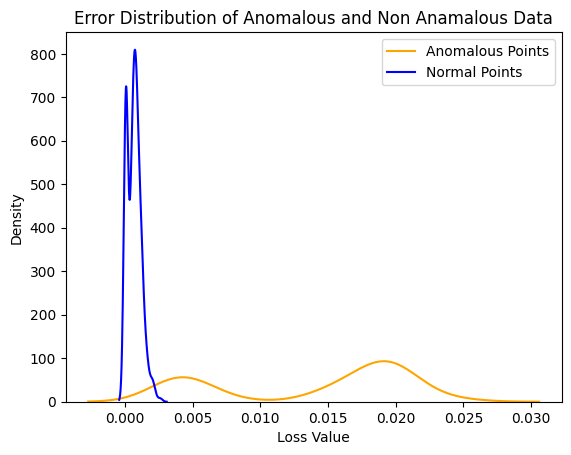

In [ ]:
sns.kdeplot(anomalous_loss,color='orange',label='Anomalous Points')
sns.kdeplot(non_anomalous_loss[:360],color='blue',label="Normal Points")
plt.title("Error Distribution of Anomalous and Non Anamalous Data")
plt.xlabel("Loss Value")
plt.legend()
plt.savefig('kde_plot_global_allnon_8latent.jpg')
plt.show()

# Federated Learning Setup

## Goals:
1. train autoencoder record loss for each epoch

In [ ]:
def create_clients(Xdata, label_list, num_clients=3, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''
    import random

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(Xdata, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}


In [ ]:
clients = create_clients(embeddings, embeddings, num_clients=3, initial='client')

In [ ]:
# Function to train the autoencoder on a client's data
def train_on_client(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for data in dataloader:
        inputs = data[0].cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, inputs)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to perform federated averaging
def federated_average(models):
    new_model = Autoencoder()

    # Aggregate the parameters
    for new_param, *client_params in zip(new_model.parameters(), *[model.parameters() for model in models]):
        new_param.data = sum(client_param.data for client_param in client_params) / len(models)

    return new_model


# Dummy data for demonstration purposes
# Replace this with your actual federated data setup
ds = [torch.tensor(i).cuda() for i in list(clients.values())]
client_data = [ds[0], ds[1], ds[2]]
client_dataloaders = [torch.utils.data.DataLoader(data, batch_size=32, shuffle=True) for data in client_data]

# Instantiate Autoencoder models for each client
client_models = [Autoencoder().to(device) for _ in range(3)]

# Hyperparameters
lr = 0.001
criterion = nn.MSELoss()
global_loss = []
clients_loss = {0:[],1:[],2:[]}
# Training loop for each client
for eps in range(500):
  for i in range(3):
      optimizer = optim.Adam(client_models[i].parameters(), lr=lr)
      lossr = 0
      for epoch in range(5):  # Replace with your desired number of epochs
          loss = train_on_client(client_models[i], client_dataloaders[i], optimizer, criterion, 'cuda')
          lossr+=loss
          print(f"Client {i + 1}, Epoch {epoch + 1}, Loss: {loss}")
      lossr/=5
      clients_loss[i].append(lossr)

  global_model = federated_average(client_models)
  input = torch.tensor(embeddings).cuda()
  outputs = global_model(inputs)
  loss = criterion(outputs, inputs)
  global_loss.append(loss)
  print("Federated Averaging Complete for epoch:",eps)
  print(clients_loss)
  print(global_loss)
global_loss = np.array(global_loss)
np.save("federated_loss_500_epochs",global_loss)

Federated Averaging Complete for epoch: 0 Loss: 0.17977915704250336
Federated Averaging Complete for epoch: 1 Loss: 0.1571492850780487
Federated Averaging Complete for epoch: 2 Loss: 0.13519148528575897
Federated Averaging Complete for epoch: 3 Loss: 0.11178035289049149
Federated Averaging Complete for epoch: 4 Loss: 0.08957785367965698
Federated Averaging Complete for epoch: 5 Loss: 0.0748118981719017
Federated Averaging Complete for epoch: 6 Loss: 0.06393139809370041
Federated Averaging Complete for epoch: 7 Loss: 0.06063152477145195
Federated Averaging Complete for epoch: 8 Loss: 0.05855431407690048
Federated Averaging Complete for epoch: 9 Loss: 0.05600985139608383
Federated Averaging Complete for epoch: 10 Loss: 0.05705792456865311
Federated Averaging Complete for epoch: 11 Loss: 0.055454056710004807
Federated Averaging Complete for epoch: 12 Loss: 0.0552280955016613
Federated Averaging Complete for epoch: 13 Loss: 0.05467986315488815
Federated Averaging Complete for epoch: 14 Los

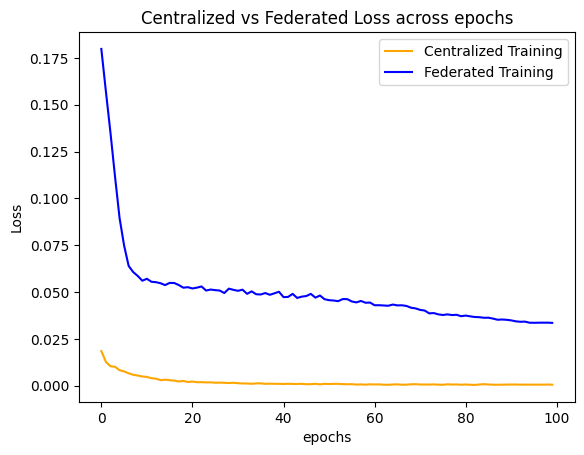